In [14]:
# Import necessary libraries

# Data manipulation
import pandas as pd
import numpy as np

# Statistical functions
from scipy.stats import zscore

# For concurrency (running functions in parallel)
from concurrent.futures import ThreadPoolExecutor

# For caching (to speed up repeated function calls)
from functools import lru_cache

# For progress tracking
from tqdm import tqdm

# Plotting and Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Language Detection packages
# `langdetect` for detecting language
from langdetect import detect as langdetect_detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
# `langid` for an alternative language detection method
from langid import classify as langid_classify

# Text Preprocessing and NLP
# Stopwords (common words to ignore) from NLTK
from nltk.corpus import stopwords
# Tokenizing sentences/words
from nltk.tokenize import word_tokenize
# Part-of-speech tagging
from nltk import pos_tag
# Lemmatization (converting words to their base form)
from nltk.stem import WordNetLemmatizer
import nltk
# Regular expressions for text pattern matching
import re

# Word Cloud generation
from wordcloud import WordCloud

In [15]:
import os
import sys
from pathlib import Path

if "workding_dir" not in locals():
    workding_dir = str(Path.cwd().parent)
os.chdir(workding_dir)
sys.path.append(workding_dir)
print("working dir:", workding_dir)

working dir: /Users/inflaton/code/engd/papers/DM-Fake-News-Detection


In [16]:
from datasets import load_dataset, concatenate_datasets, Dataset

datasets = load_dataset(
    "csv",
    data_files={
        "train": [
            "dataset/train_data_1.csv",
            "dataset/train_data_2.csv",
            "dataset/train_data_3.csv",
            "dataset/train_data_4.csv",
        ],
        "test": "dataset/test_data.csv",
        "rewritten_train": [
            "dataset/rewritten_train_data_1.csv",
            "dataset/rewritten_train_data_2.csv",
            "dataset/rewritten_train_data_3.csv",
            "dataset/rewritten_train_data_4.csv",
        ],
        "rewritten_test": "dataset/rewritten_test_data.csv",
    },
)
datasets

DatasetDict({
    train: Dataset({
        features: ['label', 'full_content', 'processed_full_content'],
        num_rows: 54441
    })
    test: Dataset({
        features: ['label', 'full_content', 'processed_full_content'],
        num_rows: 6050
    })
    rewritten_train: Dataset({
        features: ['label', 'full_content', 'processed_full_content'],
        num_rows: 54441
    })
    rewritten_test: Dataset({
        features: ['label', 'full_content', 'processed_full_content'],
        num_rows: 6050
    })
})

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def create_basic_nn(vocab_size=10000, embedding_dim=128, input_length=300, dense_units=64, dropout_rate=0.5, l2_lambda=0.01):
    """Creates a simple feedforward neural network with an embedding layer and configurable dense units."""
    
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=input_length),
        Flatten(),  # Flatten the embedding output
        Dense(dense_units, activation='relu', kernel_regularizer=l2(l2_lambda)),  
        Dropout(dropout_rate),  
        Dense(dense_units // 2, activation='relu', kernel_regularizer=l2(l2_lambda)), 
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_lambda))
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model



In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def evaluate_model(model, train_data, val_data):
    """Evaluates the trained NN model."""
    print("📊 Evaluating Model...")

    max_words = 10000
    max_sequence_length = 300

    train_texts = train_data["processed_full_content"]
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(train_texts)

    y_val = val_data["label"]
    val_texts = val_data["processed_full_content"]

    # Convert validation text into padded sequences using the same tokenizer
    X_val = pad_sequences(tokenizer.texts_to_sequences(val_texts), maxlen=max_sequence_length)

    # Predict and threshold
    y_pred = (model.predict(X_val) > 0.5).astype(int).reshape(-1)

    # Compute evaluation metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1: {f1:.4f}")

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1_score": f1}


In [28]:
train_data = datasets["train"].to_pandas()
val_data = datasets["test"].to_pandas()
data = pd.concat([train_data, val_data], ignore_index=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60491 entries, 0 to 60490
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   label                   60491 non-null  int64 
 1   full_content            60491 non-null  object
 2   processed_full_content  60491 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [29]:
# load model
from tensorflow.keras.models import load_model

model = load_model("results/NN_model_original.keras")
model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)        │ (None, 300, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 38400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 64)             │     2,457,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,219,333 (42.80 MB)

 Trainable params: 3,739,777 (14.27 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,479,556 (28.53 MB)

In [30]:
%%time
perf_original_model_val_data = evaluate_model(model, train_data, val_data)

📊 Evaluating Model...
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Accuracy: 0.9646
Precision: 0.9645
Recall: 0.9543
F1: 0.9594
CPU times: user 7.86 s, sys: 280 ms, total: 8.14 s
Wall time: 7.39 s


In [31]:
val_data_rewritten = datasets["rewritten_test"].to_pandas()
train_data_rewritten = datasets["rewritten_train"].to_pandas()

In [32]:
%%time

perf_original_model_val_data_rewritten = evaluate_model(model, train_data, val_data_rewritten)

📊 Evaluating Model...
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
Accuracy: 0.7977
Precision: 0.8531
Recall: 0.6494
F1: 0.7375
CPU times: user 7.64 s, sys: 260 ms, total: 7.9 s
Wall time: 7.17 s


In [33]:
train_data_combined = pd.concat([train_data, train_data_rewritten], ignore_index=True)
val_data_combined = pd.concat([val_data, val_data_rewritten], ignore_index=True)

In [34]:
model_combined = load_model("results/NN_model_combined.keras")
model_combined.summary()

Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_41 (Embedding)        │ (None, 300, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_41 (Flatten)            │ (None, 38400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 64)             │     2,457,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_82 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_124 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_83 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_125 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,219,333 (42.80 MB)

 Trainable params: 3,739,777 (14.27 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,479,556 (28.53 MB)

In [35]:
perf_combined_model_val_data = evaluate_model(model_combined, train_data_combined, val_data)

📊 Evaluating Model...
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Accuracy: 0.9597
Precision: 0.9605
Recall: 0.9467
F1: 0.9536


In [36]:
perf_combined_model_val_data_rewritten = evaluate_model(model_combined, train_data_combined, val_data_rewritten)

📊 Evaluating Model...
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
Accuracy: 0.8942
Precision: 0.8849
Recall: 0.8716
F1: 0.8782


In [37]:
model_rewritten = load_model("results/NN_model_rewritten.keras")
model_rewritten.summary()

Model: "sequential_62"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_62 (Embedding)        │ (None, 300, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_62 (Flatten)            │ (None, 38400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_186 (Dense)               │ (None, 64)             │     2,457,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_124 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_187 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_125 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_188 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,219,333 (42.80 MB)

 Trainable params: 3,739,777 (14.27 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,479,556 (28.53 MB)

In [38]:
perf_rewritten_model_val_data = evaluate_model(model_rewritten, train_data_rewritten, val_data)

📊 Evaluating Model...
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Accuracy: 0.9058
Precision: 0.9740
Recall: 0.8062
F1: 0.8822


In [39]:
perf_rewritten_model_val_data_rewritten = evaluate_model(model_rewritten, train_data_rewritten, val_data_rewritten)

📊 Evaluating Model...
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
Accuracy: 0.8864
Precision: 0.8977
Recall: 0.8357
F1: 0.8656


Results saved to results/Simple Neural Network_metrics.csv


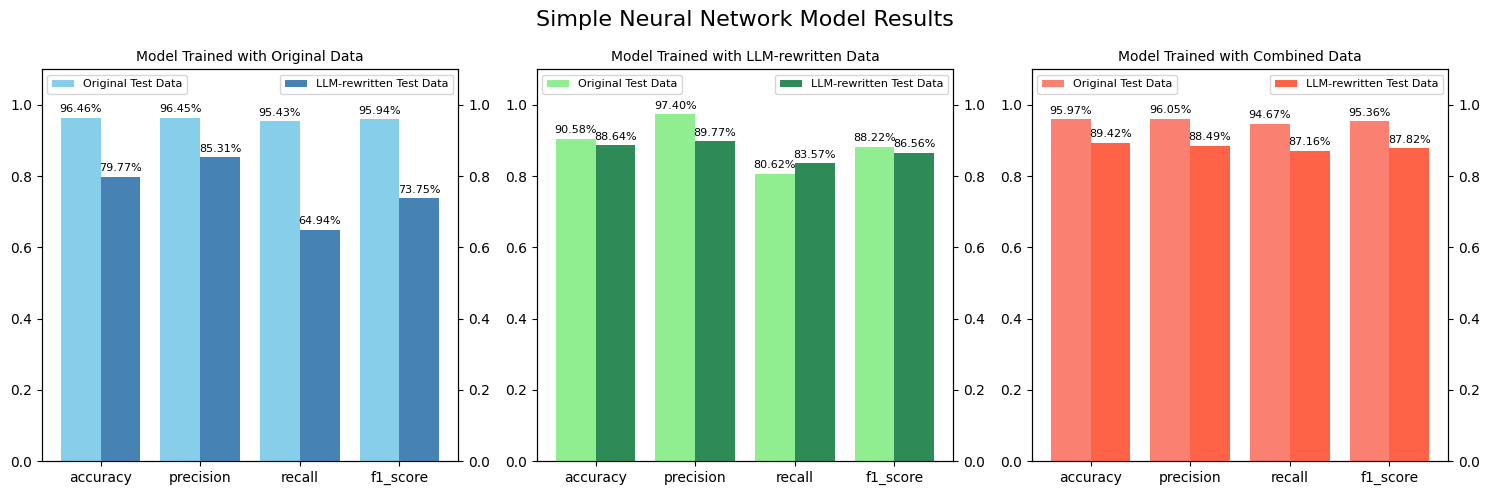

In [40]:
from llm_experiements.utils import *

model = "Simple Neural Network"
save_results(model, perf_original_model_val_data, perf_original_model_val_data_rewritten, 
             perf_combined_model_val_data, perf_combined_model_val_data_rewritten, 
             perf_rewritten_model_val_data, perf_rewritten_model_val_data_rewritten)

plot_results(model, perf_original_model_val_data, perf_original_model_val_data_rewritten, 
             perf_combined_model_val_data, perf_combined_model_val_data_rewritten, 
             perf_rewritten_model_val_data, perf_rewritten_model_val_data_rewritten)